Potato Leaf Disease Detection using Dense Convolutional Neural Network (D-CNN)

This script implements a Dense Convolutional Neural Network to detect potato leaf diseases,
specifically early blight and late blight, and compares its performance with a standard CNN.

Author: Naser Alkuhili
Date: 07/11/2024

References:
[1] G. Huang, Z. Liu, L. Van Der Maaten, and K. Q. Weinberger, "Densely Connected Convolutional Networks," in *2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*, 2017, pp. 2261-2269.
[2] "PlantVillage Dataset," https://data.mendeley.com/datasets/tywbtsjrjv/1.

Note: This script uses external libraries such as TensorFlow and Keras, which are not authored by me.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, Concatenate,
                                     GlobalAveragePooling2D, Dense)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageEnhance
import yaml



In [2]:
# Load configuration from YAML file
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Model parameters from config
input_shape = tuple(config['model']['input_shape'])
num_classes = config['model']['num_classes']
dropout_rate = config['model']['dropout_rate']
batch_size = config['training']['batch_size']
epochs = config['training']['epochs']
learning_rate = config['training']['learning_rate']

In [3]:
# Dense Block
def dense_block(x, num_layers, growth_rate, dropout_rate):
    for _ in range(num_layers):
        conv = Conv2D(growth_rate, (3, 3), padding="same", activation="relu")(x)
        conv = Dropout(dropout_rate)(conv)
        x = Concatenate()([x, conv])  # Concatenate the input and output of each layer
    return x

# Transition Layer
def transition_layer(x, reduction):
    x = Conv2D(int(x.shape[-1] * reduction), (1, 1), padding="same", activation="relu")(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x

# Input Layer
input_layer = Input(shape=input_shape)
x = Conv2D(64, (7, 7), strides=(2, 2), padding="same", activation="relu")(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

# Dense Blocks and Transition Layers
x = dense_block(x, num_layers=4, growth_rate=32, dropout_rate=dropout_rate)
x = transition_layer(x, reduction=0.5)
x = dense_block(x, num_layers=4, growth_rate=32, dropout_rate=dropout_rate)
x = transition_layer(x, reduction=0.5)

# Global Average Pooling and Output Layer
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(dropout_rate)(x)
output_layer = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)


In [4]:
optimizer = SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [5]:
# Custom Augmentation Function
def augment_image(image):
    # Check if image is in float32 and rescaled
    if image.dtype == np.float32 and image.max() <= 1.0:
        # Convert from float32 to uint8 [0,255]
        image = (image).astype(np.uint8)
    else:
        image = image.astype(np.uint8)

    # Check image shape
    if image.shape[2] == 1:
        # Convert grayscale to RGB
        image = np.concatenate([image]*3, axis=2)

    # Convert numpy array to PIL Image
    image = Image.fromarray(image)

    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Reduce brightness
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(0.8)  # Reduce brightness
    # Increase contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.8)  # Increase contrast
    # Increase saturation
    enhancer = ImageEnhance.Color(image)
    image = enhancer.enhance(1.8)  # Increase saturation


    image = np.array(image)
    
    # Convert back to float32
    image = image.astype(np.float32)
    return image


# Data Augmentation and Generators
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=augment_image
)

# Load Train Data
train_generator = datagen.flow_from_directory(
    '/Users/nfk/Documents/CS512-project-data/train',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode="sparse",
    seed=42
)

# Load Validation Data
validation_generator = datagen.flow_from_directory(
    '/Users/nfk/Documents/CS512-project-data/val',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode="sparse",
    seed=42
)

# Define the preprocessing function
def preprocess_test_image(image):
    if image.dtype == np.float32 and image.max() <= 1.0:
        image = (image).astype(np.uint8)
    else:
        image = image.astype(np.uint8)

    if image.shape[2] == 1:
        image = np.concatenate([image] * 3, axis=2)

    image = Image.fromarray(image)

    if image.mode != 'RGB':
        image = image.convert('RGB')

    image = ImageEnhance.Brightness(image).enhance(0.8)  # Reduce brightness
    image = ImageEnhance.Contrast(image).enhance(1.8)  # Increase contrast
    image = ImageEnhance.Color(image).enhance(1.8)  # Increase saturation

    image = np.array(image).astype(np.float32)
    return image

# Set up the test data generator with the preprocessing function
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_test_image)

# Load test data without augmentation, applying only the preprocessing function
test_generator = test_datagen.flow_from_directory(
    '/Users/nfk/Documents/CS512-project-data/test',
    target_size=(224, 224),  # Assuming input size is 224x224
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)




Found 2100 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


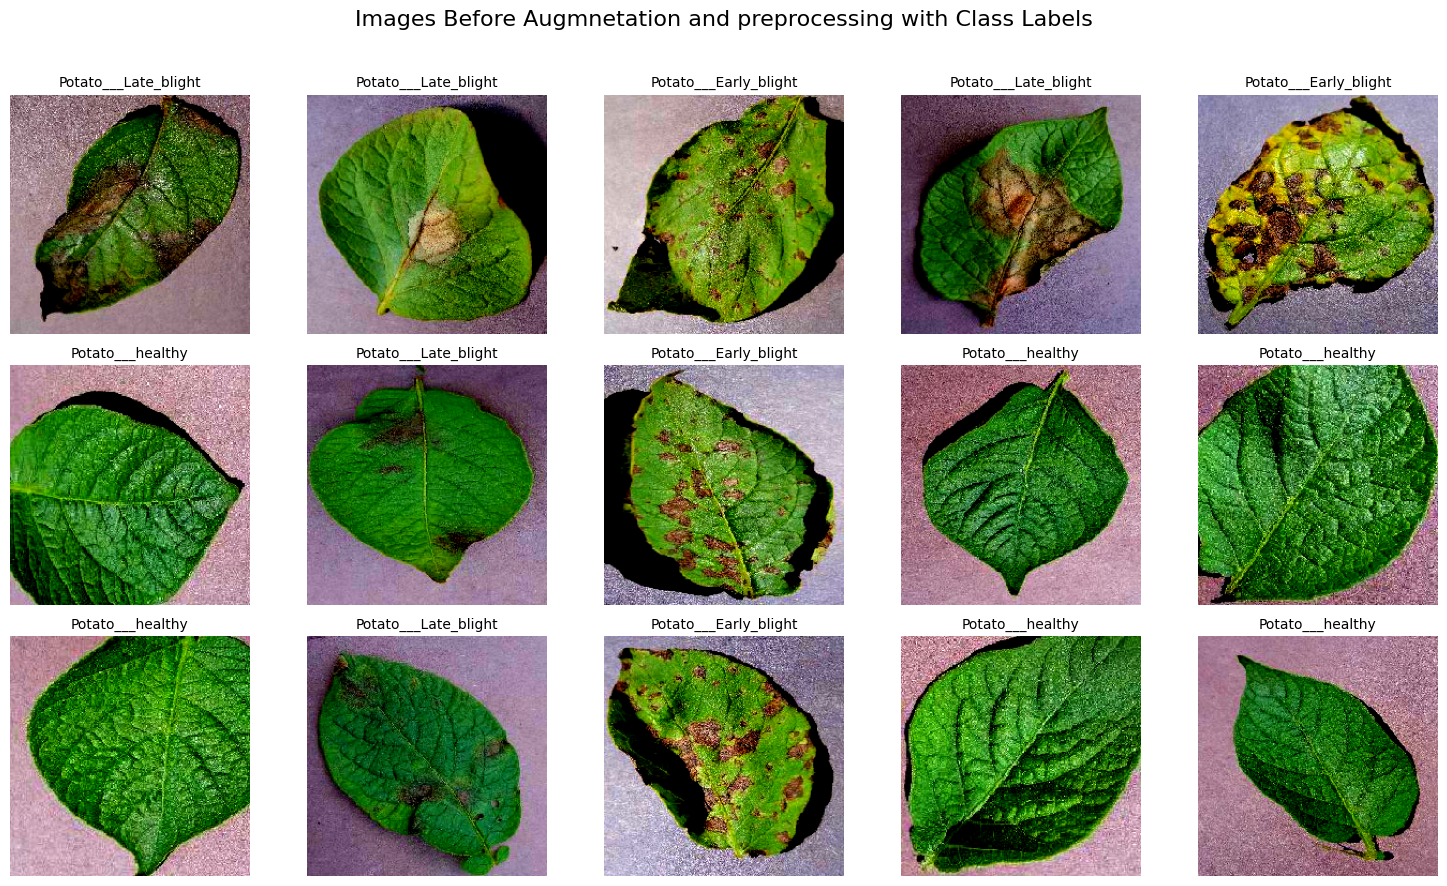

In [6]:
augmented_images, labels = next(train_generator)  # Obtain images and labels from generator

class_indices = {v: k for k, v in train_generator.class_indices.items()}  # Map indices to class labels
class_labels = [class_indices[label] for label in labels[:15]]  # Get class names for the first 15 images

# 15 images in a 3x5 grid with class labels above
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle("Images Before Augmnetation and preprocessing with Class Labels", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(augmented_images[i].astype("uint8"))  
    ax.set_title(class_labels[i], fontsize=10)  
    ax.axis("off") 

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [7]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)


/Users/nfk/miniconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.5178 - loss: 5.6483 - val_accuracy: 0.9000 - val_loss: 0.3347
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.8001 - loss: 0.4924 - val_accuracy: 0.7817 - val_loss: 0.4556
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.8447 - loss: 0.4081 - val_accuracy: 0.9217 - val_loss: 0.2299
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8948 - loss: 0.2797 - val_accuracy: 0.7533 - val_loss: 0.5128
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8833 - loss: 0.2830 - val_accuracy: 0.9300 - val_loss: 0.1853
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.8917 - loss: 0.2669 - val_accuracy: 0.9483 - val_loss: 0.1472
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9271 - loss: 0.1876 - val_accuracy: 0.9467 - val_loss: 0.1502
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.9052 - loss: 0.2324 - val_accuracy: 0.

In [8]:
# Save the trained model as an .h5 file
model.save('Dense-CNN.h5')

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - accuracy: 0.9947 - loss: 0.0336
Test Accuracy: 0.99


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step
Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.99      0.99       100
 Potato___Late_blight       0.98      1.00      0.99       100
     Potato___healthy       1.00      0.99      0.99       100

             accuracy                           0.99       300
            macro avg       0.99      0.99      0.99       300
         weighted avg       0.99      0.99      0.99       300



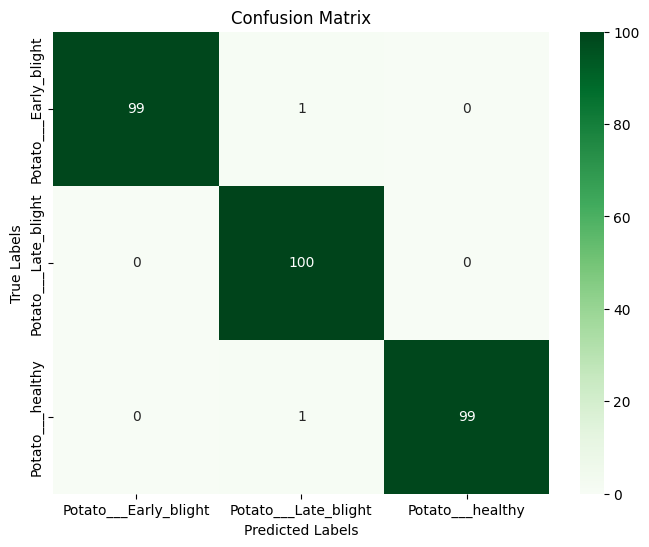

In [10]:
# Confusion Matrix and Classification Report
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification metrics
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

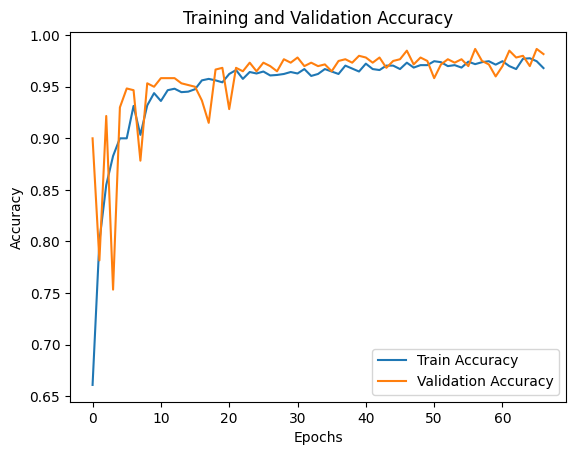

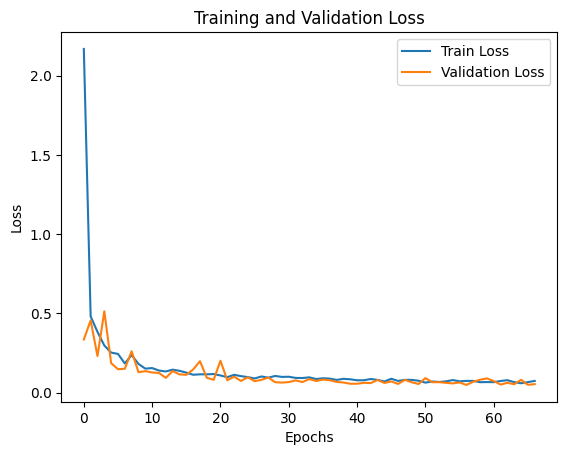

In [11]:
# Plot Training History
def plot_training_history(history):
    # Accuracy Plot
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    # Loss Plot
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)


***

**Evaluate Pre-Trained Model on Test Data without Retraining**

This code allows you to skip the training phase by loading a pre-trained model saved as `Dense-CNN.h5`. Use this script if you already have the model file (available in model.txt) and want to directly evaluate its performance on test data, generating metrics such as accuracy, a classification report, and a confusion matrix.

In [12]:
# import tensorflow as tf
# from tensorflow.keras.models import load_model, Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from PIL import Image, ImageEnhance
# import yaml



# # Load configuration from YAML file
# with open("config.yaml", "r") as file:
#     config = yaml.safe_load(file)

# # Model parameters from config
# input_shape = tuple(config['model']['input_shape'])
# num_classes = config['model']['num_classes']
# dropout_rate = config['model']['dropout_rate']
# batch_size = config['training']['batch_size']
# epochs = config['training']['epochs']
# learning_rate = config['training']['learning_rate']


# # Load the saved best model
# model = load_model('Dense-CNN.h5')

# # Define the preprocessing function
# def preprocess_test_image(image):
#     # Ensure the image is in uint8 format
#     if image.dtype == np.float32 and image.max() <= 1.0:
#         image = (image).astype(np.uint8)
#     else:
#         image = image.astype(np.uint8)

#     # Convert grayscale to RGB if needed
#     if image.shape[2] == 1:
#         image = np.concatenate([image] * 3, axis=2)

#     # Convert numpy array to PIL Image
#     image = Image.fromarray(image)

#     # Ensure image is in RGB mode
#     if image.mode != 'RGB':
#         image = image.convert('RGB')

#     # Apply brightness, contrast, and saturation adjustments
#     image = ImageEnhance.Brightness(image).enhance(0.8)  # Reduce brightness
#     image = ImageEnhance.Contrast(image).enhance(1.8)  # Increase contrast
#     image = ImageEnhance.Color(image).enhance(1.8)  # Increase saturation

#     # Convert back to numpy array and normalize to float32
#     image = np.array(image).astype(np.float32)
#     return image

# # Set up the test data generator with the preprocessing function
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_test_image)

# # Load test data without augmentation, applying only the preprocessing function
# test_generator = test_datagen.flow_from_directory(
#     '/Users/nfk/Documents/CS512-project-data/test',
#     target_size=(224, 224),  # Assuming input size is 224x224
#     batch_size=32,
#     class_mode="sparse",
#     shuffle=False
# )

# # Evaluate the model on test data
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

# # Confusion Matrix and Classification Report
# y_true = test_generator.classes
# y_pred = model.predict(test_generator)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Classification metrics
# print("Classification Report:")
# print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# # Confusion Matrix
# conf_matrix = confusion_matrix(y_true, y_pred_classes)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix")
# plt.show()
